In [452]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as FF
from sklearn.datasets import load_iris
!pip install torchviz

from torchviz import make_dot

torch.set_default_dtype(torch.float32)


# vector calculus R^n -> R

## dummy examples

In [453]:
# R->R
# f(x) = x^2
x = torch.tensor(2.0, requires_grad=True)
f = x**2

f.backward()
x.grad   # at x = 2 the gradient of f(x) is 2x = 2*2 = 4

tensor(4.)

In [454]:
# R^n -> R
# f(x1,x2) = x1^2 + 2x2

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(3.0, requires_grad=True)

f = x1**2 + 3*x2

f.backward()
x1.grad, x2.grad

(tensor(4.), tensor(3.))

In [455]:
# R^n -> R
# f(x1,x2) = x1^2 + 2x2
# x1 and x2 depend on t R -> R^2 (input t and output x1,x2)
t = torch.tensor(3.0, requires_grad = True)

x1 = 2*t
x2 = 3*t**3

f = x1**2 + 3*x2

f.backward()
t.grad

tensor(267.)

## Vector example

**f: R^3 -> R**

and

**x: R^2 -> R**

In [456]:
# R^n -> R
# f(x1,x2,x3) = x1^2 + 2x2 + sin(x3)
# x1, x2, x3 depend on t and s R^2->R^3 (input t and s and output x1,x2,x3)
t = torch.tensor(3.0, requires_grad = True)
s = torch.tensor(4.0, requires_grad=True)

x1 = 2*t+s**3
x2 = 3*t**3/s
x3 = torch.sin(t)*s

f = x1**2 + 3*x2 + torch.sin(x3)

f.backward()
print("∂f/∂t =", t.grad.item())
print("∂f/∂s =", s.grad.item())

∂f/∂t = 337.40435791015625
∂f/∂s = 6704.931640625


 ## let's calculate the jacobian

In [457]:
# we can rewrite it as:
t = torch.tensor(3.0, requires_grad = True)
s = torch.tensor(4.0, requires_grad=True)
def f_of_ts(t,s):
    # R^2 -> R
    x1 = 2*t + s**3
    x2 = 3*t**3 / s
    x3 = torch.sin(t) * s
    return x1**2 + 3*x2 + torch.sin(x3)

J_f_ts = torch.autograd.functional.jacobian(f_of_ts, (t, s))
torch.stack(J_f_ts, dim = 0)
# ∂f/∂t, ∂f/∂s


tensor([ 337.4044, 6704.9316])

In [458]:
# we can rewrite it as 2 parts, the jacobian from f to x and the jacobian from x to (t,s):
x1 = 2*t+s**3
x2 = 3*t**3/s
x3 = torch.sin(t)*s

def f_of_x(x1,x2,x3):
  # gradient
  return x1**2 + 3*x2 + torch.sin(x3)

J_f_x = torch.autograd.functional.jacobian(f_of_x, (x1,x2,x3))
J_f_x_ = torch.stack(J_f_x, dim = 0)
J_f_x_
# [∂f/∂x1, ∂f/∂x2 , ∂f/∂x3]
# 1x3

tensor([140.0000,   3.0000,   0.8449])

In [459]:
t = torch.tensor(3.0, requires_grad=True)
s = torch.tensor(4.0, requires_grad=True)

def x_of_ts(t, s):
    # R^2-->R^3
    x1 = 2*t + s**3
    x2 = 3*t**3 / s
    x3 = torch.sin(t) * s
    return torch.stack([x1, x2, x3])  # vector R^3

J_x_ts = torch.autograd.functional.jacobian(x_of_ts, (t, s))
J_x_ts_ = torch.stack(J_x_ts, dim = 1)
J_x_ts_
# [∂x1/∂t , ∂x2/∂s]
# [∂x2/∂t , ∂x2/∂s]
# [∂x3/∂t , ∂x3/∂s]
# 3x2

tensor([[ 2.0000, 48.0000],
        [20.2500, -5.0625],
        [-3.9600,  0.1411]])

In [460]:
# J_f_ts = torch.stack(J_f_x, dim = 0) @ torch.stack(J_x_ts, dim = 1) # 2x1
J_f_ts = J_f_x_ @ J_x_ts_
J_f_ts

# the result is exactly the same as the one we found before when we computed the jacobian directly for f_of_ts

tensor([ 337.4044, 6704.9316])

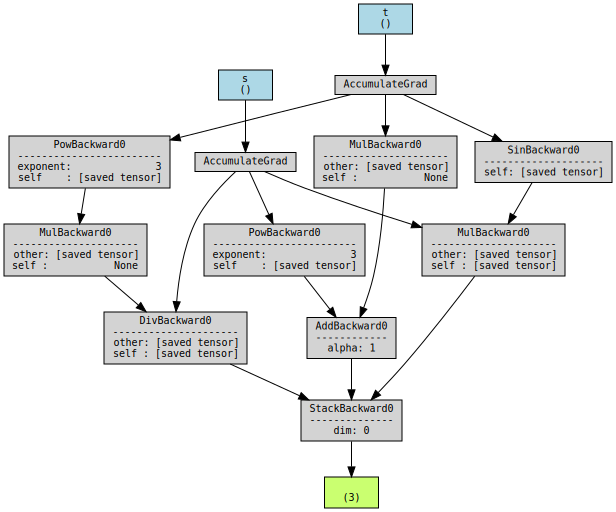

In [461]:
logits = x_of_ts(t, s)
dot = make_dot(logits, params={"t":t, "s":s}, show_attrs=True)
dot


## viz

In [462]:
#############################################################################
# fun functions:
def f_of_ts(t, s):
    return torch.sin(t) * torch.cos(s) + t**2 - s**2
# def f_of_ts(t, s):
#     return torch.atan2(s, t + 1e-3) + 0.1*(t**2 + s**2)
# def f_of_ts(t, s):
#     return torch.sin(t**2 + s**2) + 0.5*torch.cos(3*t)*torch.sin(2*s)
#############################################################################
# original function:
# def f_of_ts(t,s):
#     """R^2 -> R"""
#     x1 = 2*t + s**3
#     x2 = 3*t**3 / s
#     x3 = torch.sin(t) * s
#     return x1**2 + 3*x2 + torch.sin(x3)
#############################################################################
n = 50
t_vals = torch.linspace(-n/2, n/2, n, dtype=torch.float64)
s_vals = torch.linspace(-n/2, n/2, n, dtype=torch.float64)

results = torch.zeros((n,n,2))
for i,ti in enumerate(t_vals):
  jacobian_row = []
  for j,sj in  enumerate(s_vals):
    ti = ti.clone().requires_grad_(True) # to avoid warning
    sj = sj.clone().requires_grad_(True) # to avoid warning
    J = torch.autograd.functional.jacobian(f_of_ts, (ti, sj))
    results[i][j] = torch.stack(J, dim=0) # [df/dt, df/ds]

results.shape


torch.Size([50, 50, 2])

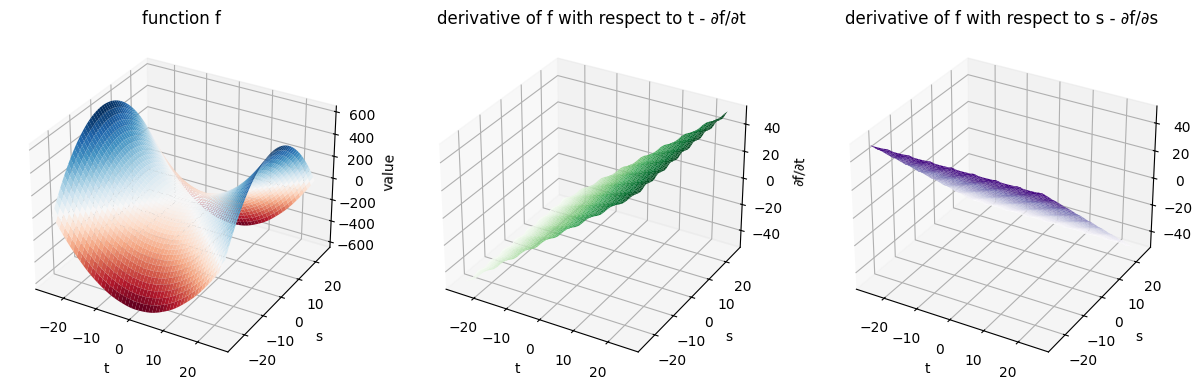

In [463]:
fig, ax = plt.subplots(1,3, figsize = (15,15),subplot_kw={"projection": "3d"})

ax[0].plot_surface(*torch.meshgrid(t_vals,s_vals),f_of_ts(*torch.meshgrid(t_vals,s_vals)), cmap = "RdBu")
ax[1].plot_surface(*torch.meshgrid(t_vals,s_vals),results[:,:,0], cmap = "Greens")
ax[2].plot_surface(*torch.meshgrid(t_vals,s_vals),results[:,:,1], cmap = "Purples")

ax[0].set_title("function f")
ax[0].set_xlabel("t")
ax[0].set_ylabel("s")
ax[0].set_zlabel("value")

ax[1].set_title("derivative of f with respect to t - ∂f/∂t")
ax[1].set_xlabel("t")
ax[1].set_ylabel("s")
ax[1].set_zlabel("∂f/∂t")

ax[2].set_title("derivative of f with respect to s - ∂f/∂s")
ax[2].set_xlabel("t")
ax[2].set_ylabel("s")
ax[2].set_zlabel("∂f/∂s")
plt.show()
# t and s are modifying the value of the function via x1,x2 and x3.
# nota bene:  ∂f/∂t dipende anche dal valore di s, this is because when computing the derivative wrt t for f --> some dependencies for s remain,
# for example, consider the function:
# f(x1,x2) = x1+3*x2
# x1 = s+3t
# x2 = s*t^2+s^2
# apply the chain rule:
# ∂f/∂t = ∂f/∂x1 * ∂x1/∂t +  ∂f/∂x2 * ∂x2/∂t = (1)*(3) + (3)*(2t*s) = 3+6ts
# ∂f/∂s = ∂f/∂x1 * ∂x1/∂s +  ∂f/∂x2 * ∂x2/∂s = (1)*(1) + (3)*(t^2 + 2s) = 1 + 3t^2 + 6s
# as we can see both the functions dependencie for both t and s

# expression above is equivalent to:
# [∂f/∂x1, ∂f/∂x2] @ [[∂x1/∂t,∂x1/∂s],[∂x2/∂t, ∂x2/∂s]] = [∂f/∂t,∂f/∂s]



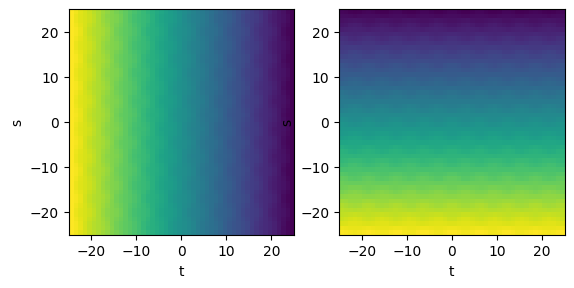

In [464]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(results[:,:,1],extent=[t_vals.min(), t_vals.max(), s_vals.min(), s_vals.max()],)
ax[1].imshow(results[:,:,0],extent=[t_vals.min(), t_vals.max(), s_vals.min(), s_vals.max()],)

for a in ax:
  a.set_xlabel("t")
  a.set_ylabel("s")

In [465]:
# we can also show the gradient of the function using arrows.
# given a meshgrid, we can trace from each one of its points an arrow
# which will have it's head at the value corresponding to (∂f/∂t, ∂f/∂s)

n = 30
t_vals = torch.linspace(-n/2, n/2, n, dtype=torch.float64)
s_vals = torch.linspace(-n/2, n/2, n, dtype=torch.float64)

results = torch.zeros((n,n,2))
for i,ti in enumerate(t_vals):
  jacobian_row = []
  for j,sj in  enumerate(s_vals):
    ti = ti.clone().requires_grad_(True) # to avoid warning
    sj = sj.clone().requires_grad_(True) # to avoid warning
    J = torch.autograd.functional.jacobian(f_of_ts, (ti, sj))
    results[i][j] = torch.stack(J, dim=0) # [df/dt, df/ds]

results.shape


torch.Size([30, 30, 2])

In [466]:
T,S = torch.meshgrid(t_vals, s_vals)
df_dt = results[:,:,0]
df_ds = results[:,:,1]

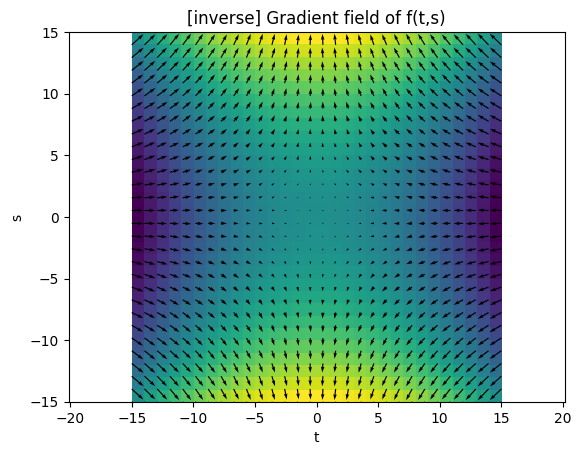

In [467]:
fig,ax = plt.subplots(1,1)

ax.quiver(T,S, -df_dt, -df_ds)
ax.imshow(f_of_ts(*torch.meshgrid(t_vals,s_vals)),extent=[t_vals.min(), t_vals.max(), s_vals.min(), s_vals.max()],)
ax.set_xlabel("t")
ax.set_ylabel("s")
ax.set_title("[inverse] Gradient field of f(t,s)")
ax.axis("equal")
plt.show()
# each arrow represents the direction where we have to head in order (in the s,t coordinate plane) for the function f to increase.

# let's see it working with R^n -> R^m

**f: R^n -> R^m**

and

**x: R^2 -> R**

In [537]:
# vector valued functions are functions like:

# F = (f1(x1...xn), f2(x1 .. xn), ... , fm(x1...xn))
# a practica example is:
def F_of_x(x: torch.tensor):
  """a function that takes a 1x4 input and returns a 6x1 output"""
  A = torch.normal(0,1,(6,4), dtype = torch.float32, requires_grad=True )
  b = torch.normal(0,1,(6,1),requires_grad=True)
  return A@x + b # 6x4 @ 4x1 + 6x1 = 6x1

F_of_x(torch.tensor([1,2,3,4],dtype = torch.float32).unsqueeze(dim = 1))

tensor([[ 2.4496],
        [-5.5336],
        [ 0.8061],
        [-0.3874],
        [ 2.4188],
        [-0.8219]], grad_fn=<AddBackward0>)

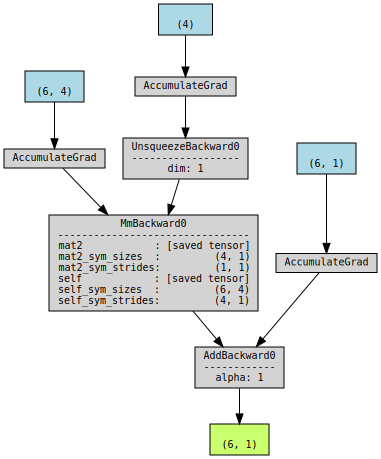

In [539]:
logits = F_of_x(torch.tensor([1,2,3,4],dtype = torch.float32, requires_grad=True).unsqueeze(dim = 1))
dot = make_dot(logits, show_attrs=True)
dot


F(x)=Ax+b

In [470]:
# the one above is a classical example of a EXTREMELY simple Neural Net, where we input a 4x1 vector (the dataset features)
# and we output a 6x1 vector, that can be interpreted for example as probabilities, or we can just pass them to other layers of the model

## NN

In [471]:
# let's try to recreate a really small neural net:
A = torch.normal(0,1,(6,4), dtype = torch.float32)
b = torch.normal(0,1,(6,1))
# A and b are initialized ONE time, and set as input to calculate the gradient
def F_of_x(A,b, x: torch.tensor):
  """a function that takes a 1x4 input and returns a 6x1 output"""
  return A@x + b # 6x4 @ 4x1 + 6x1 = 6x1

F_of_x(A,b,torch.tensor([1,2,3,4],dtype = torch.float32).unsqueeze(dim = 1))

tensor([[-1.5914],
        [-1.8240],
        [-0.4496],
        [-6.6872],
        [ 5.5722],
        [ 2.8040]])

In [472]:
# we can calculate the jacobian, it is gona be a matrix that contains the partial derivative
# of F wrt x1,x2,x3,x4. thus it is gona be a 6x4 matrix, exactly like the matrix A,
# and it will have the same exact values, because the derivative of a constant multiplied by x will be the constant (Ax)
x0 = torch.tensor([1,2,3,4], dtype=torch.float32).unsqueeze(1)  # 4x1

J_F_of_x = torch.autograd.functional.jacobian(F_of_x, (A,b,x0) )
J_A, J_b, J_x = J_F_of_x

In [473]:
J_A.squeeze().shape, J_A.shape
# ∂F/∂A, ∂F/∂b, ∂F/∂x
# per interpretazione delle dimnensioni guarda pagina 137. in particolare nel caso 6,6,4
# --> rappresenta che abbiamo fatto il gradiente di un vettore 6x1 (OUTPUT) rispetto a una matrice 6x4

# for each of the 6 outputs, you have a 6×4 gradient matrix wrt A.

(torch.Size([6, 6, 4]), torch.Size([6, 1, 6, 4]))

In [474]:
torch.allclose(J_x.reshape(A.shape),A) # as we can see the derivative is exactly A.

True

### a closer look into multi dimensional tensors

**GENEARL RULE
 Jacobian shape = output.shape+input.shape.**

In [475]:
#book example, where we have a matrix A 4x2 that depends on a vector x 3x1
x = torch.tensor([1., 2., 3.])

# Define a matrix A(x) of shape (4,2) depending on x
def A(x):
    return torch.stack([
        torch.stack([x[0] + x[1], x[2]**2]),
        torch.stack([x[1] * x[2], torch.sin(x[0])]),
        torch.stack([x[0] * x[2], x[1]**2]),
        torch.stack([x.sum(), x.prod()])
    ])

# Now compute Jacobian of A wrt x
J_ = torch.autograd.functional.jacobian(A, x)
print(J_.shape)  # (4,2,3)
# x INPUT (3)
# A(x) is a function with dimension (4,2)

# this is because we have the partial derivative of each element in the matrix 4x2 with respect to each element in the vector

torch.Size([4, 2, 3])


In [476]:
A = torch.tensor([[2,3,5],[5,3,4],[4,5,3],[5,4,6]],dtype = torch.float32)
x = torch.tensor([[1],[2],[3]], dtype = torch.float32)
# x = torch.tensor([1,2,3], dtype = torch.float32).view(-1,1)

f = lambda x: A @ x

J_ = torch.autograd.functional.jacobian(f, x)
J_.shape
# here we have a simple multiplication, thus the result is A it self
# x is (3,1) INPUT
# A is (4,3)
# f(x) = A @ x is (4,1) OUTPUT
# So raw Jacobian shape = (4,1,3,1)
# to get just A we can easily squeeze the matrix

torch.Size([4, 1, 3, 1])

In [477]:
A = torch.tensor([[2,3,5],[5,3,4],[4,5,3],[5,4,6]],dtype = torch.float32)
x = torch.tensor([[1,2],[3,2],[4,5]], dtype = torch.float32)

f = lambda x: A @ x

J_ = torch.autograd.functional.jacobian(f, x).squeeze()
J_.shape
# here we have a simple multiplication, thus the result is A it self
# x is (3,2)  INPUT
# A is (4,3)
# f(x) = A @ x is (4,2) OUTPUT
# So raw Jacobian shape = (4,2,3,2)

torch.Size([4, 2, 3, 2])

## really build it [Jacobian - inefficient]

In [478]:
# now we can add a bit of non linearity
input_layer_dimension = 4
hidden__layer_dimension = 4
output_layer_dimension = 3
A1 = torch.normal(0,1,(hidden__layer_dimension,input_layer_dimension), dtype = torch.float32)
b1 = torch.normal(0,1,(hidden__layer_dimension,1),dtype = torch.float32)
A2 = torch.normal(0,1,(output_layer_dimension,hidden__layer_dimension), dtype = torch.float32)
b2 = torch.normal(0,1,(output_layer_dimension,1),dtype = torch.float32)

def F_of_x(A1,A2,b1,b2, x):
  """a function that takes a 1x4 input and returns a 4x1 output"""
  return FF.softmax(A2@FF.relu(A1@x + b1) + b2, dim = 0)

x0 = torch.tensor([1,2,3,4],dtype = torch.float32).unsqueeze(dim = 1)
F_of_x(A1,A2,b1,b2,x0) # forward pass

tensor([[0.0271],
        [0.0029],
        [0.9700]])

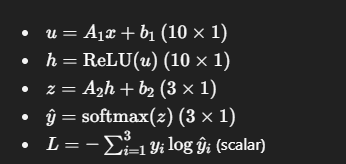

In [479]:
# J_F_of_x = torch.autograd.functional.jacobian(F_of_x, (A1,A2,b1,b2,x0))
# J_A1,J_A2, J_b1,J_b2, J_x = J_F_of_x
# J_A1,J_A2, J_b1,J_b2, J_x = J_A1.squeeze(),J_A2.squeeze(), J_b1.squeeze(),J_b2.squeeze(), J_x.squeeze()

# we don't need anymore to compute these, because we are going to define a function that takes in input
# A1,A2,b1,b2,x0 and the target variable, and tells us in output how bad the model is. then we are goign to compute the jacobian on that.

In [480]:
# load the data
data = load_iris()
X, y = torch.tensor(data.data, dtype = torch.float32), torch.tensor(data.target)  # X is (150,4), y is (150,)
X.shape,y.shape
y_one_hot_encoded = FF.one_hot(y)

In [481]:
# try a forward pass with data
x0 = X[0].reshape((X[0].shape[0],1))#.unsqueeze(dim = 1)
F_of_x(A1,A2,b1,b2,x0) # forward pass

tensor([[1.0000e+00],
        [7.3917e-12],
        [1.5883e-08]])

In [482]:
# define the cross entropy we are going to use:
# def cross_entropy_loss(pred, target):
#   eps = 1e-9
#   return -sum([y_i_target * torch.log(y_i_pred+ eps) for y_i_target,y_i_pred in zip(pred,target)])
# y0 = y_one_hot_encoded[0]
# cross_entropy_loss(pred = x0, target = y0)

In [483]:
# in order to compute the jacobian we need it to have as input all the inputs of F_of_x:
def cross_entropy_loss(target,A1,A2,b1,b2, x):
  eps = 1e-9
  y_pred = F_of_x(A1,A2,b1,b2,x) # forward pass
  return -sum([y_i_target * torch.log(y_i_pred+eps) for y_i_target,y_i_pred in zip(y_pred,target)])

#### ONE PASS

In [484]:
i = 40
y0 = y_one_hot_encoded[i].to(dtype = torch.float32)
x0 = X[i].unsqueeze(dim = 1)

In [485]:
# now we can easily calculate the derivative of the loss function with respect to the parameters
cross_entropy_loss(y0,A1,A2,b1,b2,x0)

tensor([4.7724e-07])

In [486]:
J_LOSS_of_x = torch.autograd.functional.jacobian(cross_entropy_loss, (y0,A1,A2,b1,b2, x0))
J_y0, J_A1,J_A2, J_b1,J_b2, J_x = J_LOSS_of_x

In [487]:
J_y0, J_A1, J_A2, J_b1, J_b2, J_x = J_y0.reshape(y0.shape),J_A1.reshape(A1.shape),J_A2.reshape(A2.shape), J_b1.reshape(b1.shape),J_b2.reshape(b2.shape), J_x.reshape(x0.shape)

In [488]:
lr = 10e-20
A1 = A1-lr*J_A1
A2 = A2-lr*J_A2
b1 = b1-lr*J_b1
b2 = b2-lr*J_b2
cross_entropy_loss(y0,A1,A2,b1,b2,x0)

tensor([4.7724e-07])

#### making more passes

In [489]:
# number of samples to pick each epoch
batch_size = 100
lr = 1e-2

for epoch in range(10):
    perm = torch.randperm(len(X)) # take a random permutation of the indexes of x
    # take a random subset
    batch_idx = perm[:batch_size]

    for i in batch_idx:
        y0 = y_one_hot_encoded[i].to(dtype=torch.float32)
        x0 = X[i].unsqueeze(1)

        # compute loss
        loss = cross_entropy_loss(y0, A1, A2, b1, b2, x0)

        # jacobian wrt parameters
        J = torch.autograd.functional.jacobian(
            cross_entropy_loss, (y0, A1, A2, b1, b2, x0)
        )
        _, J_A1, J_A2, J_b1, J_b2, _ = J

        # reshape
        J_A1 = J_A1.reshape(A1.shape)
        J_A2 = J_A2.reshape(A2.shape)
        J_b1 = J_b1.reshape(b1.shape)
        J_b2 = J_b2.reshape(b2.shape)

        # update step
        A1 = A1 - lr * J_A1
        A2 = A2 - lr * J_A2
        b1 = b1 - lr * J_b1
        b2 = b2 - lr * J_b2

    print(f"epoch {epoch} loss:", loss.item())


epoch 0 loss: 20.723264694213867
epoch 1 loss: 1.9138281004416058e-06
epoch 2 loss: 20.7232666015625
epoch 3 loss: 20.7232666015625
epoch 4 loss: 20.7232666015625
epoch 5 loss: 4.944734541822982e-07
epoch 6 loss: 20.7232666015625
epoch 7 loss: 20.723264694213867
epoch 8 loss: 9.152488473773701e-07
epoch 9 loss: 20.7232608795166


In [490]:
k = 23
x_test = X[k].unsqueeze(dim = 1)
y_test = y[k]
print("target:",y_test.item(),"| prediction:", torch.argmax(F_of_x(A1,A2,b1,b2, x_test)).item())

target: 0 | prediction: 0


In [491]:
colormap = []
for n,x_i in enumerate(X):
  # print(x_i)
  x_test = X[n].unsqueeze(dim = 1)
  y_test = y[n]
  prediction = torch.argmax(F_of_x(A1,A2,b1,b2, x_test)).item()
  # print("target:",y_test.item(),"| prediction:", prediction )
  colormap.append(prediction)


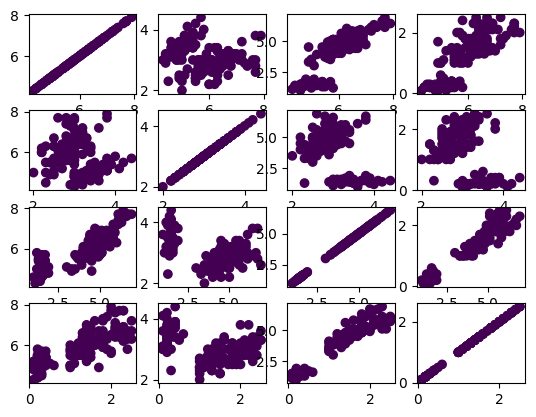

In [492]:
# colormap = y
fig, ax = plt.subplots(4,4)
for i, obi in enumerate(ax):
  for j, obj in enumerate(obi):
    # if i > j:
      ax[i][j].scatter(X[:, i], X[:,j], c=colormap, cmap='viridis')

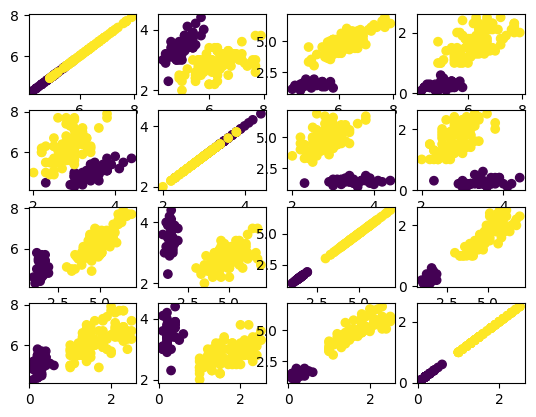

## really building it this time - i swear [backpropagation]

In [493]:
# WHY what i made is SUPER inefficient:

# given:
# F_of_x(A1,A2,b1,b2, x_test)
# calculating the Jacobian for each parameter makes autograd recompute many overlapping
# partial derivatives, essentially repeating work that backprop would have shared.
# when we calculate the derivative for the loss with respect to A2 for we compute some derivative,
# but we can USE it to calculate [via the chain rule] the derivative of A1. if we recompute the Jacobian
# for eah one of the parameter, than when we calculate the derivative of loss wrt A1 we are RECALCULATING
# all the previous derivatives (that are in any case needed to the jacobian to compute the gradient for A1)
# without considering that ALL the previous derivatives have already been calculated!! (beause A1 is the "first parameter of the model").

# it is like if we go back and forth all the times.

# another thing is that we are calculating the gradients for x and y, they are useless because they represent the input and output, and cannot be changed

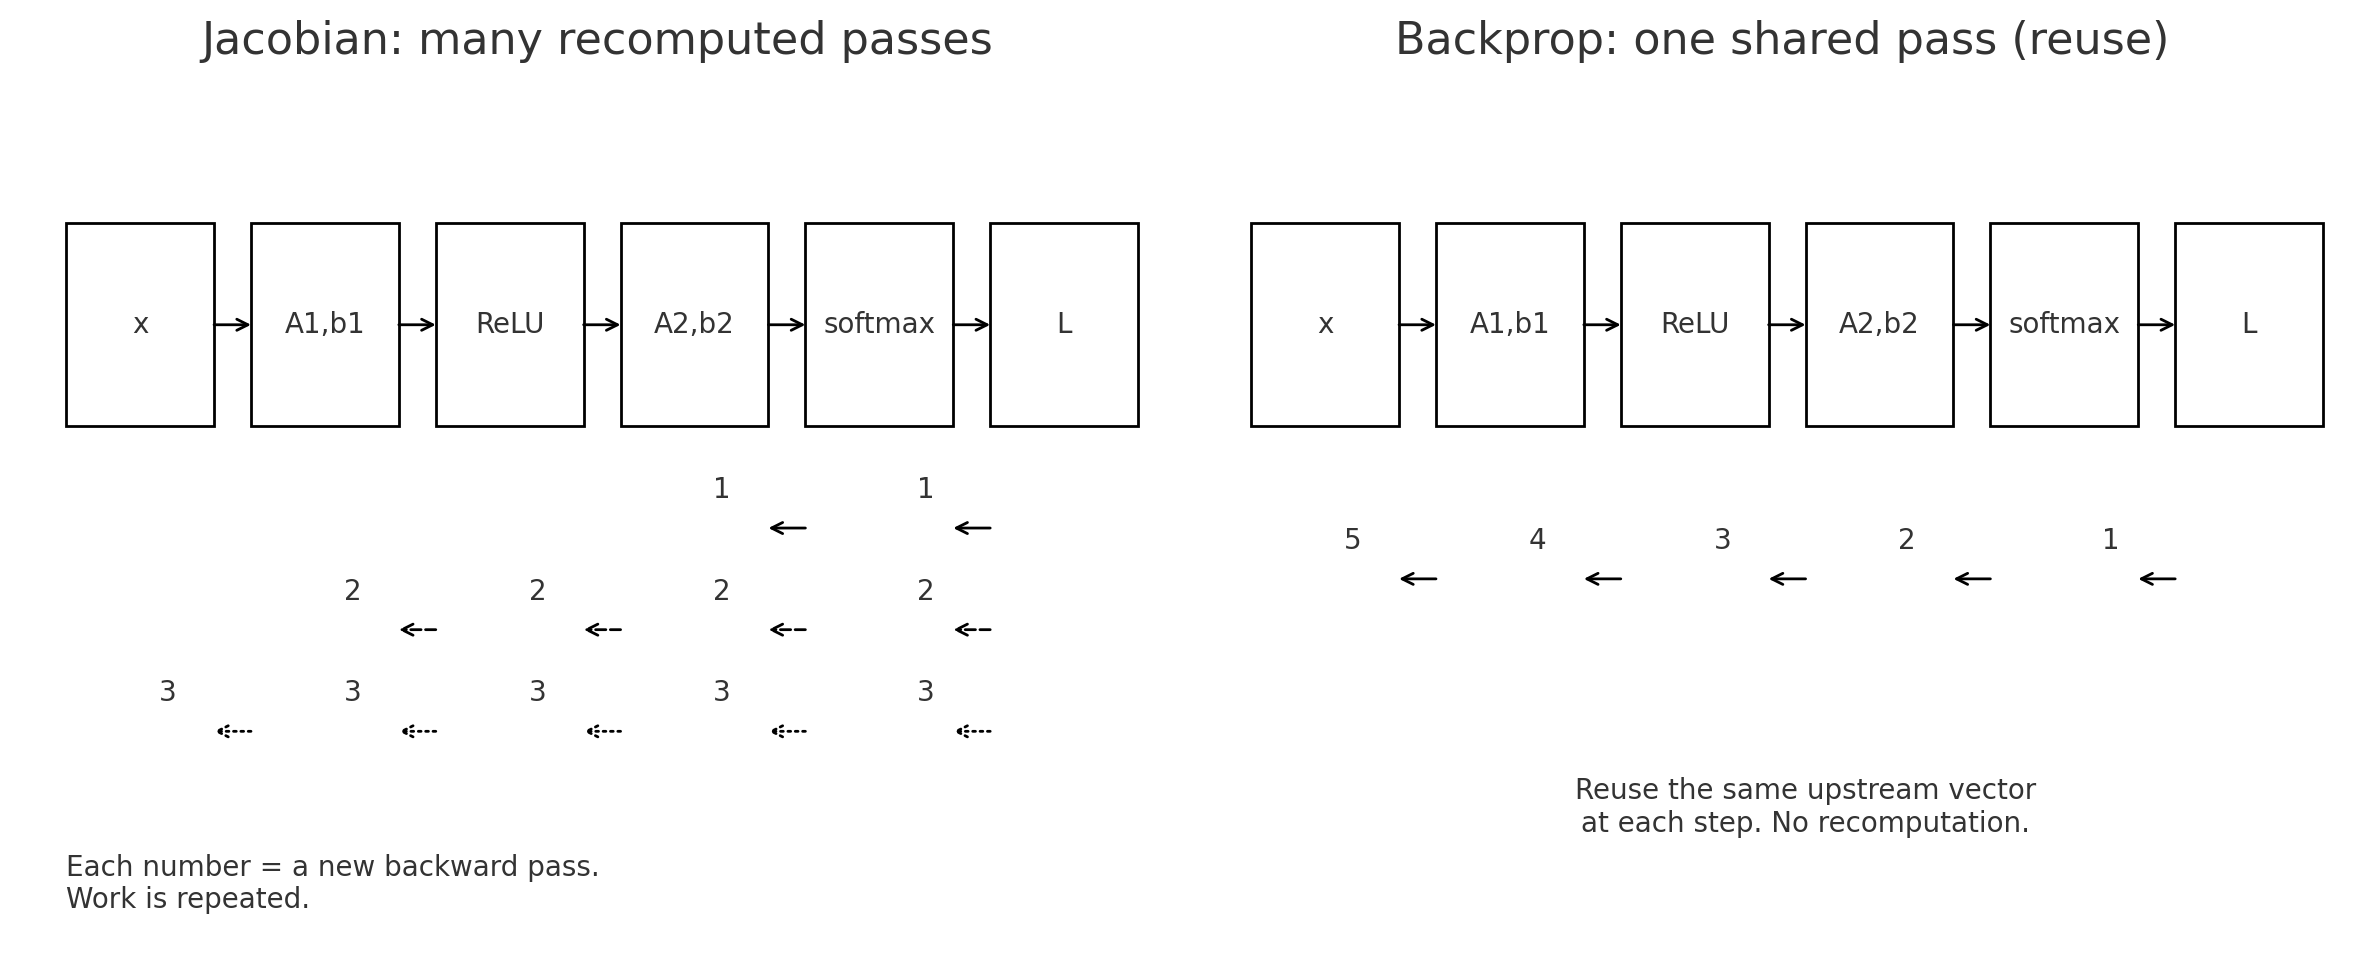

In [494]:
# IT is extremely important to tell torch which are the elements of which we want to calculate the gradient, we do that with requires_grad
# in this way we can also avoid calculating the gradient for the x and ys as we were doing before
input_layer_dimension = 4
hidden__layer_dimension = 20
output_layer_dimension = 3
A1 = torch.normal(0,1,(hidden__layer_dimension,input_layer_dimension), dtype = torch.float32,requires_grad=True) # 20x4
b1 = torch.normal(0,1,(hidden__layer_dimension,1),dtype = torch.float32,requires_grad=True) # 20x1
A2 = torch.normal(0,1,(output_layer_dimension,hidden__layer_dimension), dtype = torch.float32,requires_grad=True) # 3x20
b2 = torch.normal(0,1,(output_layer_dimension,1),dtype = torch.float32,requires_grad=True)# 3x1

def F_of_x(A1,A2,b1,b2, x):
  """a function that takes a 1x4 input and returns a 4x1 output"""
  return FF.softmax(A2@FF.relu(A1@x + b1) + b2, dim = 0)

# x0 = torch.tensor([1,2,3,4],dtype = torch.float32).unsqueeze(dim = 1)
# torch.argmax(F_of_x(A1,A2,b1,b2,x0)) # forward pass

In [495]:
def cross_entropy_loss(predictions, target):
  eps = 1e-9
  return -sum([y_i_target * torch.log(y_i_pred+eps) for y_i_target,y_i_pred in zip(predictions,target)])

In [496]:
# load the data and EXPLICTLY TELL torch not to keep gradient to X and y (defaulted False in any case)
data = load_iris()
X, y = torch.tensor(data.data, dtype = torch.float32, requires_grad = False), torch.tensor(data.target,requires_grad = False)  # X is (150,4), y is (150,)
X.shape,y.shape
y_one_hot_encoded = FF.one_hot(y)

### first pass step by step:

In [497]:
xi = X[0].unsqueeze(dim = 1)
yi= y_one_hot_encoded[0]
prediction = F_of_x(A1,A2,b1,b2,xi)
loss = cross_entropy_loss(prediction,yi)

In [498]:
print(loss)
A1.grad # no gradient


tensor([20.7233], grad_fn=<NegBackward0>)


In [499]:
# now to calculate the gradients, just call loss.backward() --> this will compute the grandients at EACH step and put them into the matrices A1,A2...
loss.backward()

In [500]:
A1.grad # gradient!!

tensor([[-2.5588e-42, -1.7558e-42, -7.0205e-43, -1.0089e-43],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-5.6472e-43, -3.8676e-43, -1.5554e-43, -2.2421e-44],
        [ 6.2526e-42,  4.2908e-42,  1.7166e-42,  2.4523e-43],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.3864e-42,  1.6381e-42,  6.5581e-43,  9.3887e-44],
        [ 2.0655e-42,  1.4181e-42,  5.6753e-43,  8.1275e-44],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.8597e-42,  3.3351e-42,  1.3340e-42,  1.9058e-43],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.3799e-42,  2.3206e-42,  9.2766e-43,  1.3312e-43],
        [ 7.0065e-45,  5.6052e-45,  1.4013e-45,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.5943e-42,  2.4663e-42,  9.8651e-43,  1.4153e-43],
        

In [501]:
xi.grad # we told torch to NOT keep track of the gradient this time!

In [502]:
# now we can update the weights of our janky model
lr = 1e-2
with torch.no_grad(): # without this, the tensors would be re-created and defaulted to require_grad = False, grad would also be deleted because A1 is re-instanciated
# by using this context manager, we are telling pytorch to update our A1, and not recreate it
  A1 -=  lr * A1.grad
  A2 -=  lr * A2.grad
  b1 -=  lr * b1.grad
  b2 -=  lr * b2.grad

# nice explanation:
# A1 = A1 - lr * A1.grad
# This creates a new tensor object on the right-hand side, then rebinds the name A1 to it.
# The new tensor is not the same leaf parameter anymore, so autograd stops tracking it.

# A1 -= lr * A1.grad inside with torch.no_grad():
# This performs an in-place update on the existing tensor’s data.
# The object in memory stays the same, it still has requires_grad=True, and autograd will keep tracking it in the next backward.





In [503]:
# gradients are stored inside the object and cumulated by default, we have to manually set them to zero at each step
A1.grad.zero_()
A2.grad.zero_()
b1.grad.zero_()
b2.grad.zero_()

tensor([[0.],
        [0.],
        [0.]])

### let's iterate

In [504]:
losses =  []
batch_size = 5
lr = 1e-20

for epoch in range(4):
    perm = torch.randperm(len(X))
    batch_idx = perm[:batch_size]

    for i in batch_idx:
      # FORWARD pass
      xi = X[i].unsqueeze(dim = 1)
      yi= y_one_hot_encoded[i]
      # CALCULATE THE LOSS R^n -> R
      prediction = F_of_x(A1,A2,b1,b2,xi)
      loss = cross_entropy_loss(prediction, yi)
      losses.append(loss.detach().numpy() )
      # BACKWARD pass
      loss.backward()

      # UPDATE pass
      with torch.no_grad(): # without this, the tensors would be re-created and defaulted to require_grad = False
        A1 -= lr * A1.grad
        A2 -= lr * A2.grad
        b1 -= lr * b1.grad
        b2 -= lr * b2.grad

      # SET TO ZERO THE GRADIENTS
      # in torch gradients accumulate (summed to the previous value) by default, thus we have to set them to zero manually
      A1.grad.zero_()
      A2.grad.zero_()
      b1.grad.zero_()
      b2.grad.zero_()

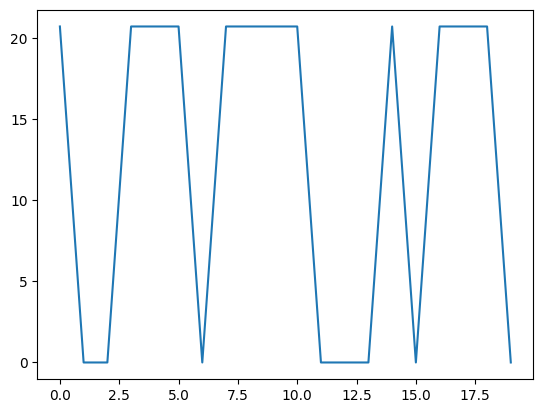

In [505]:
fig,ax = plt.subplots(1,1)
ax.plot(losses)
# TRAINING is REALLY Jumpy --> reason? --> we are updating at each data point.

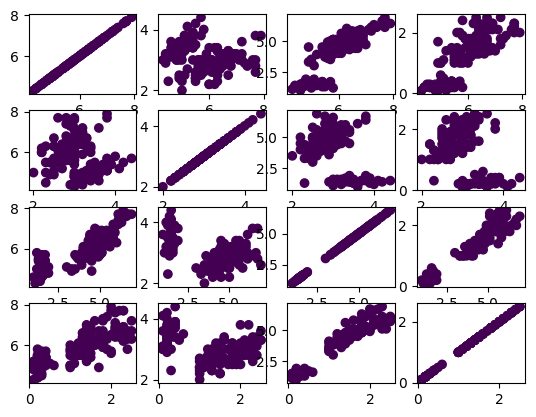

In [506]:
colormap = []
for n,x_i in enumerate(X):
  # print(x_i)
  x_test = X[n].unsqueeze(dim = 1)
  y_test = y[n]
  prediction = torch.argmax(F_of_x(A1,A2,b1,b2, x_test)).item()
  # print("target:",y_test.item(),"| prediction:", prediction )
  colormap.append(prediction)

# colormap = y
fig, ax = plt.subplots(4,4)
for i, obi in enumerate(ax):
  for j, obj in enumerate(obi):
    # if i > j:
      ax[i][j].scatter(X[:, i], X[:,j], c=colormap, cmap='viridis')

## a bigger model with batches

In [507]:
# IT is extremely important to tell torch which are the elements of which we want to calculate the gradient, we do that with requires_grad
# in this way we can also avoid calculating the gradient for the x and ys as we were doing before
input_layer_dimension = 4
hidden__layer_dimension_1 = 10
hidden__layer_dimension_2 = 20
output_layer_dimension = 3
A1 = torch.normal(0,1,(hidden__layer_dimension_1,input_layer_dimension), dtype = torch.float32,requires_grad=True)      # hidden__layer_dimension_1 x input_layer_dimension
b1 = torch.normal(0,1,(hidden__layer_dimension_1,1),dtype = torch.float32,requires_grad=True)                           # hidden__layer_dimension_1 x 1
A2 = torch.normal(0,1,(hidden__layer_dimension_2,hidden__layer_dimension_1), dtype = torch.float32,requires_grad=True)  # hidden__layer_dimension_2 x hidden__layer_dimension_1
b2 = torch.normal(0,1,(hidden__layer_dimension_2,1),dtype = torch.float32,requires_grad=True)                           # hidden__layer_dimension_2 x 1
A3 = torch.normal(0,1,(output_layer_dimension,hidden__layer_dimension_2), dtype = torch.float32,requires_grad=True)     # output_layer_dimension x hidden__layer_dimension_2
b3 = torch.normal(0,1,(output_layer_dimension,1),dtype = torch.float32,requires_grad=True)                              # output_layer_dimension x 1
def F_logits(A1,A2,A3,b1,b2,b3, Xbatch):
    # Xbatch: shape (4, batch)
    h1 = torch.relu(A1 @ Xbatch + b1)   # (hidden__layer_dimension_1, batch)                                10 x batch
    h2 = torch.relu(A2 @ h1 + b2)       # (hidden__layer_dimension_2, batch)                                20 x batch
    out = A3 @ h2 + b3                  # (output_layer_dimension, batch)                                   3 x batch
    return out.T                        # (batch, output_layer_dimension) transpose for cross_entropy       batch x 3
    # this time we do NOT compute the softmax for numerical stability



In [508]:
# simple forward pass
x0 = torch.tensor([1,2,3,4], dtype = torch.float32).unsqueeze(1)
logits = F_logits(A1,A2,A3,b1,b2,b3,x0) # forward pass
logits.shape

torch.Size([1, 3])

In [509]:
x0.shape # must be a column vector, this is not ok in machine learning because normally we take the input vector as row

torch.Size([4, 1])

In [534]:
# remember that we can give as input more than one vector
fake_x0 = torch.tensor([[1,2,3,4],[23,4,5,6]],dtype = torch.float32, requires_grad=True).T
fake_targets = torch.tensor([1,2])
logits = F_logits(A1,A2,A3,b1,b2,b3, fake_x0) # the result will output_classes x batch_size --> 3x2
logits.shape,x0.shape

(torch.Size([2, 3]), torch.Size([4, 1]))

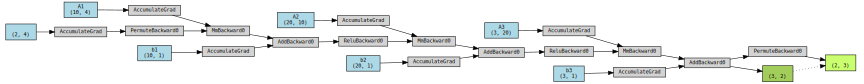

In [535]:
dot = make_dot(logits, params={"A1": A1, "A2": A2, "A3": A3,
                               "b1": b1, "b2": b2, "b3": b3,
                               "Xbatch": fake_x0})

dot.graph_attr['rankdir'] = 'LR'
dot

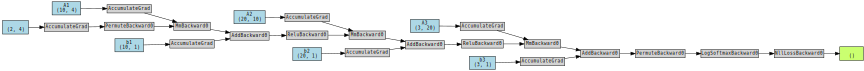

In [536]:
loss = FF.cross_entropy(logits, fake_targets)
loss # entire loss across the batch
dot = make_dot(loss, params={"A1": A1, "A2": A2, "A3": A3,
                               "b1": b1, "b2": b2, "b3": b3,
                               "Xbatch": fake_x0})

dot.graph_attr['rankdir'] = 'LR'
dot

In [513]:
# my version is really bugged and numerically unstable
def cross_entropy_loss(logits, target_onehot):
    log_probs = logits - torch.logsumexp(logits, dim=1, keepdim=True) # = log_softmax
    loss_per_sample = -(target_onehot * log_probs).sum(dim=1)
    return loss_per_sample.mean() # calculate the mean of the loss in the batch


In [514]:
losses =  []

In [515]:
batch_size = 16
lr = 1e-2
losses = []

for epoch in range(10):
    perm = torch.randperm(len(X))
    for k in range(0, len(X), batch_size):
        idx = perm[k:k+batch_size]
        xi = X[idx].T            # shape (batch, 4)
        target = y[idx]          # shape (batch,)

        # FORWARD PASS
        logits = F_logits(A1,A2,A3,b1,b2,b3, xi)

        # WE CAN SWITCH BETWEEN MY HOME MADE LOSS FUNCTION :) and the TORCH ONE :(
        ##################################################################################
        # loss = cross_entropy_loss(logits,FF.one_hot(target, num_classes=3).to(torch.float32))
        # we are using batches, we have to tell one_hot how many classes to consider otherwise it will create the one_hot with what it finds
        loss = FF.cross_entropy(logits, target)
        ##################################################################################
        losses.append(loss.item())
        # So with batch size 16, your parameter update is the same as if you
        # computed the gradient for each sample individually and then averaged them.
        # infact the process is:
        # -> The network makes 16 predictions in one go.
        # -> For each of those predictions, you could imagine computing its own loss and its own gradient (like it did for only one prediction before).
        # -> All those 16 gradients are then averaged together.
        # -> That single averaged gradient is what you use to update the weights.


        # BACKWARD PASS
        loss.backward()


        # UPDATE PASS
        with torch.no_grad():
            A1 -= lr * A1.grad
            A2 -= lr * A2.grad
            A3 -= lr * A3.grad
            b1 -= lr * b1.grad
            b2 -= lr * b2.grad
            b3 -= lr * b3.grad

        # zero grads
        A1.grad.zero_()
        A2.grad.zero_()
        A3.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()


# SMALL CLARIFICATION
# Suppose you have 2 samples in a batch.
# If you trained them one by one:
# Sample 1 would say: “update weights by +2.”
# Sample 2 would say: “update weights by +4.”
# If you average them, the update is
# (2+4)/2=3
# That’s exactly what happens with a batch: instead of doing two updates (+2, then +4), you get one update (+3).

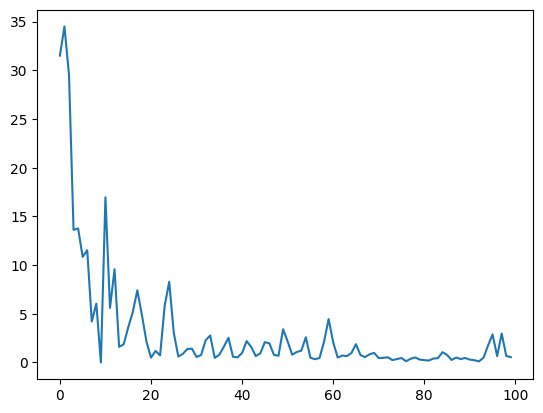

In [516]:
fig,ax = plt.subplots(1,1)
ax.plot(losses)

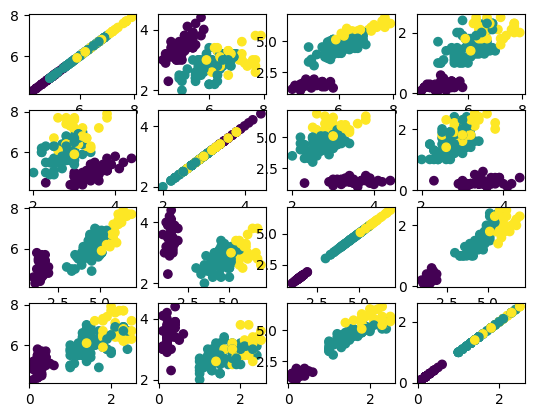

In [517]:
colormap = []
for n,x_i in enumerate(X):
  x_test = X[n].view(-1,1) #x_test = X[n].unsqueeze(dim = 1)
  y_test = y[n]
  prediction = torch.argmax(F_logits(A1,A2,A3,b1,b2,b3, x_test)).item()
  colormap.append(prediction)

# colormap = y
fig, ax = plt.subplots(4,4)
for i, obi in enumerate(ax):
  for j, obj in enumerate(obi):
    # if i > j:
      ax[i][j].scatter(X[:, i], X[:,j], c=colormap, cmap='viridis')

In [540]:
# ONE VERY IMPORTANT THING:
# here we are using the "matrix at the left" mathematical convention A@x BUT in machine learning is common to do the exact opposite:
# x@A.T

# another important thing to notice is that we can calcualte the gradient of any function with respect to any other variable.
# we USE a loss function to map the output of the model into R (now we have a function that is R^n->R), than we take the derivative of the loss function with respect
# to any of the variables. we than calculate how much we need to nudge some of the variables of the model.
# the computational graph ends with the loss function and it calculates the gradients

# backpropagation - reverse mode automatic differentiation

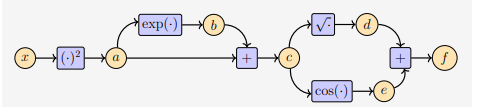
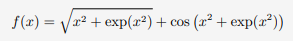

In [532]:
x = torch.tensor([1.],requires_grad=True)
a = x**2
b = torch.exp(a,)
c = a+b
d = c**0.5
e = torch.cos(c)
f = d+e

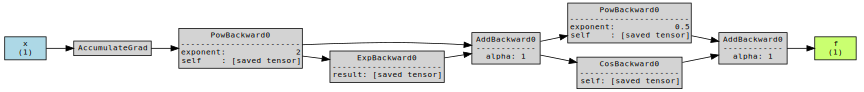

In [533]:
dot = make_dot(f, params={
    "x": x,
    "a": a,
    "b": b,
    "c": c,
    "d": d,
    "e": e,
    "f": f
}, show_attrs=True)

dot.graph_attr['rankdir'] = 'LR'
dot

In [521]:
# if we want ∂f/∂x we can use the chain rule and traverse backward the computational graph

In [529]:
x = torch.tensor([1.,4.,5.],requires_grad=True)
A = torch.tensor([[1,2,3],[4,5,3],[4,5,3]], dtype = torch.float32, requires_grad = True)

f  = A@x

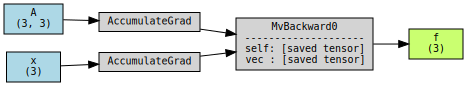

In [530]:
dot = make_dot(f, params={
    "x": x,
    "A": A,
    "f": f
}, show_attrs=True)

dot.graph_attr['rankdir'] = 'LR'
dot